In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp

from uncertainties import ufloat
from uncertainties.umath import log
from uncertainties import unumpy
import scipy as sc

In [2]:
import lbg_forecast.priors_gp_dust as gpdp
dust_prior = gpdp.DustPrior()

Loading Models
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_ef

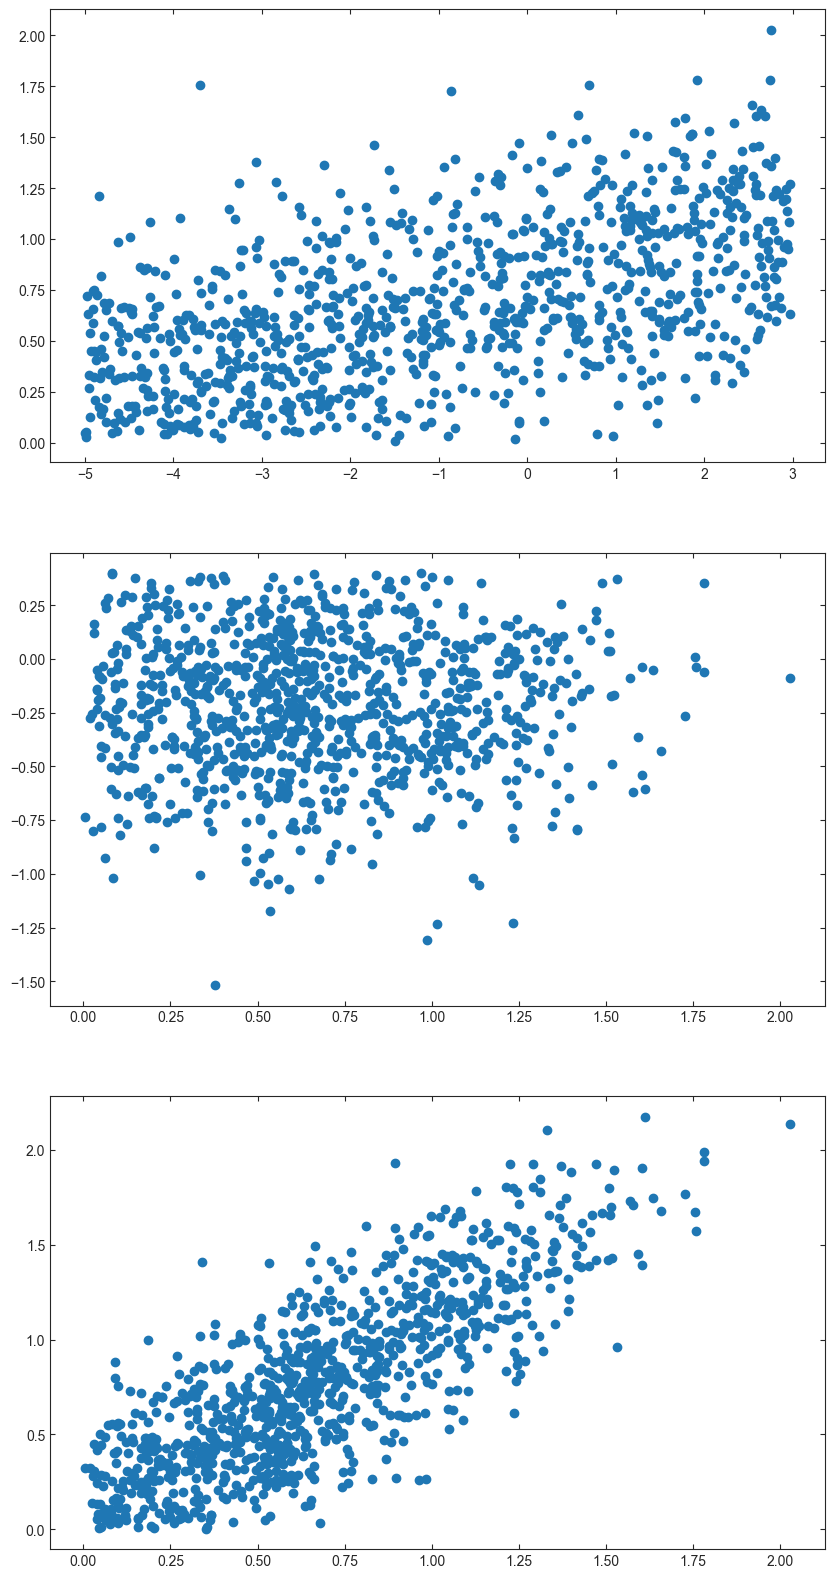

In [13]:
test_sfrs = np.random.uniform(-5, 3, 1000)
dust2samples = dust_prior.evaluate_model(dust_prior.model_dust2, test_sfrs, 0, 4, 0.05, 0.5)
dustindexsamples = dust_prior.evaluate_model(dust_prior.model_dust_index, dust2samples, -2.2, 0.4, 0.05, 0.5)
dust1samples = dust_prior.evaluate_model(dust_prior.model_dust1, dust2samples, 0, 4, 0.05, 0.5)

f, ax = plt.subplots(3, 1, figsize=(10, 20))

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

ax1.scatter(test_sfrs, dust2samples)
ax2.scatter(dust2samples, dustindexsamples)
ax3.scatter(dust2samples, dust1samples)

nsamples = 10000
popcosmos_samples = np.load("dust_data/popcosmos_parameters_rmag_lt_25.npy")[:nsamples, :]

dust_samples = popcosmos_samples[:, 8:11]
logsfrratios = popcosmos_samples[:, 2:8]
redshifts = popcosmos_samples[:, -1]
logmasses = popcosmos_samples[:, 0]
recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, 10**logmasses, logsfrratios))

dust2 = dust_samples[:, 0]
dust_index = dust_samples[:, 1]
dust1frac = dust_samples[:, 2]
dust1 = dust1frac*dust2

alpha=0.5
f, ax = plt.subplots(3, 1, figsize=(15, 20))
ax[0].scatter(dust2, dust_index, c='k', alpha=0.5)
ax[1].scatter(dust1, dust2, c='k', alpha=0.5)
ax[2].scatter(recent_sfrs, dust2, c='k', alpha=0.5)

In [4]:
def create_gp_model(lengthscale, train_x, train_y):

    class GPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(GPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood).to(torch.double)

    return model, likelihood

def create_gp_model_obs(lengthscale, train_x, train_y, noise):

    class GPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(GPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
    model = GPModel(train_x, train_y, likelihood).to(torch.double)

    return model, likelihood

def gp_training_loop(model, likelihood, train_x, train_y, training_iter, lr=1e-4):

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #i + 1, training_iter, loss.item(),
        print(loss.item())
            #model.likelihood.noise.item()
        #))
        optimizer.step()

    return model, likelihood

def gp_evaluate_model(model, likelihood, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    f_preds = model(test_x.to(torch.double))

    return f_preds

def gp_plot_confidence(f_preds, test_x, train_x, train_y, labelx, labely, alpha=0.5):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        # Plot training data as black stars
        ax.scatter(train_x.numpy(), train_y.numpy(), c='k', alpha=alpha)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), f_preds.mean, 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
        #ax.legend(['Observed Data', 'Mean', 'Confidence'])

        ax.set_xlabel(labelx)
        ax.set_ylabel(labely)


def gp_plot_confidence_obs(f_preds, test_x, train_x, train_y, train_yerrs, labelx, labely, alpha=0.5):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        # Plot training data as black stars
        ax.errorbar(train_x.numpy(), train_y.numpy(), train_yerrs.numpy(), fmt='ko', capsize=2)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), f_preds.mean, 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
        #ax.legend(['Observed Data', 'Mean', 'Confidence'])

        ax.set_xlabel(labelx)
        ax.set_ylabel(labely)

def binned_weighted_mean_std(x, y, yerr, bins):

    bin_midpoints = (bins[:-1]+bins[1:])/2
    nbins = len(bins)-1
    bin_indexes = np.digitize(x, bins)-1

    weighted_averages = []
    error = []
    non_empty_bins = []
    for bin in range(nbins):

        y_indexes = np.where(bin_indexes == bin)[0]

        if(len(y_indexes)> 0):
            y_in_bin = y[y_indexes]
            yerrs_in_bin = yerr[y_indexes]
            weights_in_bin = (1/yerrs_in_bin)**2
            weighted_average_in_bin = np.average(y_in_bin, weights=weights_in_bin)
            #error_on_wmean = np.sqrt(1/np.sum(weights_in_bin))
            std_in_bin = np.std(y_in_bin)
            avg_err_in_bin = np.mean(yerrs_in_bin)
            weighted_averages.append(weighted_average_in_bin)
            #set error floor
            if(std_in_bin<avg_err_in_bin):
                error.append(avg_err_in_bin)
            else:
                error.append(std_in_bin)
            non_empty_bins.append(bin_midpoints[bin])

    return np.array(non_empty_bins), np.array(weighted_averages), np.array(error)

train_sfrs = torch.from_numpy(recent_sfrs)
train_dust2 = torch.from_numpy(dust2)
test_sfrs = torch.linspace(-5, 3, 100)
model, likelihood = create_gp_model([3.0, 15.0], train_sfrs, train_dust2)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_sfrs, train_dust2, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
gp_plot_confidence(f_preds, test_sfrs, train_sfrs, train_dust2, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    #arr = unumpy.uarray(f_preds.mean.numpy(), f_preds.stddev.numpy())
    #arr = unumpy.exp(arr)
    #means = unumpy.nominal_values(arr)
    #stds = unumpy.std_devs(arr)
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_sfrs, means, stds)
plt.scatter(train_sfrs.numpy(), train_dust2.numpy(), c='k', alpha=alpha)

with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_sfrs.numpy(), train_dust2.numpy(), c='k', alpha=alpha)

train_dust2 = torch.from_numpy(dust2)
train_dust_index = torch.from_numpy(dust_index)
test_dust2 = torch.linspace(0, 4, 100)
model, likelihood = create_gp_model([2.0, 6.0], train_dust2, train_dust_index)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust_index, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence(f_preds, test_dust2, train_dust2, train_dust_index, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_dust2, means, stds)
plt.scatter(train_dust2.numpy(), train_dust_index.numpy(), c='k', alpha=alpha)

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_dust2.numpy(), train_dust_index.numpy(), c='k', alpha=alpha)

train_dust2 = torch.from_numpy(dust2)
train_dust1 = torch.from_numpy(dust1)
test_dust2 = torch.linspace(0, 4, 100)
model, likelihood = create_gp_model([2.0, 6.0], train_dust2, train_dust1)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust1, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence(f_preds, test_dust2, train_dust2, train_dust1, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_dust2, means, stds)
plt.scatter(train_dust2.numpy(), train_dust1.numpy(), c='k', alpha=alpha)

d2 = np.linspace(0.1,4.0,50)
dobj = DustAttnCalc()
d1sim, _ = dobj.get_d1(d2)
d1, d1e = np.average(d1sim, axis=0), np.std(d1sim, axis=0)
print("d1 values:", d1)
print("d1e values:", d1e)

plt.errorbar(d2, d1, d1e)

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_dust2.numpy(), train_dust1.numpy(), c='k', alpha=alpha)

In [5]:
ngal = 20000
#sfrsamples = np.random.uniform(-8, 2, ngal)
logM = np.random.uniform(8.74,11.30,ngal)
sfr = np.random.uniform(-2.06,2.11,ngal)
logZ = np.random.uniform(-1.70,0.18,ngal)
dobj = DustAttnCalc(sfr=sfr, logM=logM, logZ=logZ, bv=True, eff=False)
dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
M

mean: 0.05281008020273059 std: 0.006456459585082826
[-2.25 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75  2.25] [0.55518658 0.55286166 0.54337474 0.52497251 0.52083621 0.62195127
 0.75590095 0.87399709 0.988147   1.05803342] [0.14686008 0.15135877 0.16347338 0.17060702 0.18373809 0.22260799
 0.19900276 0.13299607 0.11553428 0.10761912]


<ErrorbarContainer object of 3 artists>

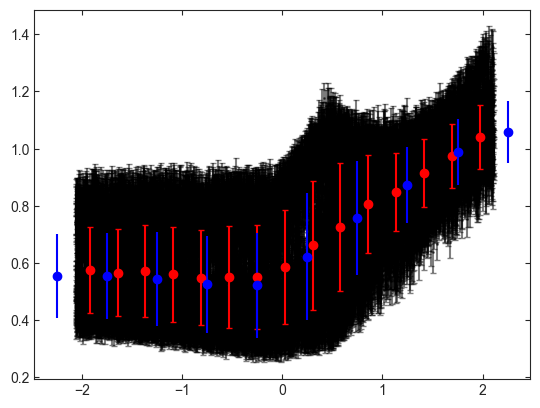

In [6]:
print("mean:", np.mean(taue), "std:", np.std(taue))
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)
bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(sfr, tau, 'mean', 15)
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(sfr, tau, 'std', 15)
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2

plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
sfr_bins = np.arange(-3, 3, 0.5)
x, y, yerr = binned_weighted_mean_std(sfr, tau, taue, sfr_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')

<ErrorbarContainer object of 3 artists>

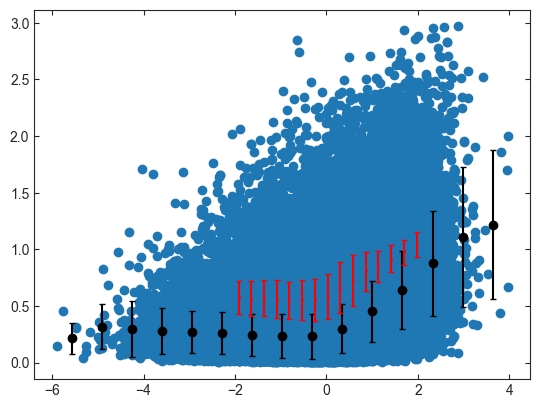

In [7]:
#sfrsamples = np.linspace(-8, 2, 20)
#dobj = DustAttnCalc(sfr=sfrsamples, bv=True, eff=False)
#dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

nsamples = 500000
popcosmos_samples = np.load("dust_data/popcosmos_parameters_rmag_lt_25.npy")[:nsamples, :]

dust_samples = popcosmos_samples[:, 8:11]
logsfrratios = popcosmos_samples[:, 2:8]
redshifts = popcosmos_samples[:, -1]
logmasses = popcosmos_samples[:, 0]
recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, 10**logmasses, logsfrratios))

dust2 = dust_samples[:, 0]
dust_index = dust_samples[:, 1]
dust1frac = dust_samples[:, 2]
dust1 = dust1frac*dust2

plt.scatter(recent_sfrs, dust2)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(recent_sfrs, dust2,'mean', 15)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(recent_sfrs, dust2,'std', 15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

tensor([-5.5679, -4.9106, -4.2534, -3.5961, -2.9389, -2.2817, -1.6244, -0.9672,
        -0.3099,  0.3473,  1.0046,  1.6618,  2.3190,  2.9763,  3.6335, -1.9209,
        -1.6430, -1.3651, -1.0871, -0.8092, -0.5313, -0.2534,  0.0245,  0.3025,
         0.5804,  0.8583,  1.1362,  1.4141,  1.6921,  1.9700],
       dtype=torch.float64) tensor([0.2137, 0.3149, 0.2967, 0.2761, 0.2670, 0.2581, 0.2462, 0.2343, 0.2301,
        0.2995, 0.4522, 0.6405, 0.8761, 1.1074, 1.2185, 0.5750, 0.5651, 0.5703,
        0.5597, 0.5477, 0.5501, 0.5506, 0.5851, 0.6616, 0.7260, 0.8055, 0.8493,
        0.9159, 0.9740, 1.0401], dtype=torch.float64) tensor([0.1363, 0.1995, 0.2458, 0.2019, 0.1860, 0.1857, 0.1848, 0.1912, 0.1973,
        0.2192, 0.2672, 0.3478, 0.4643, 0.6180, 0.6576, 0.1492, 0.1526, 0.1614,
        0.1657, 0.1671, 0.1770, 0.1833, 0.1981, 0.2254, 0.2247, 0.1718, 0.1367,
        0.1190, 0.1113, 0.1122], dtype=torch.float64)
1823.2077814238057
1767.1293264941946
1709.2242322801956
1649.6186908254592
1588.

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


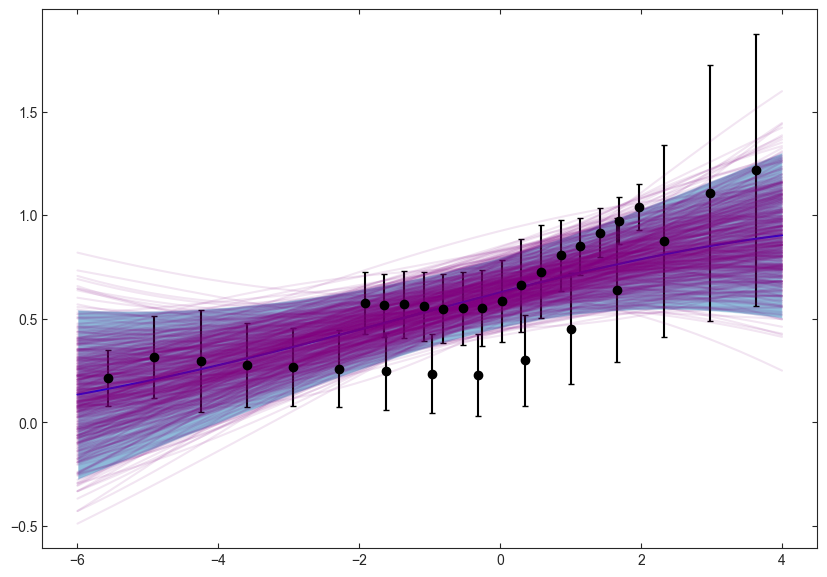

In [8]:
train_sfrs = torch.from_numpy(np.hstack((bin_centers, bin_centers_de)))
train_dust2 = torch.from_numpy(np.hstack((bin_means, bin_means_de)))
train_dust2_errs = torch.from_numpy(np.hstack((bin_std, bin_std_de)))

train_sfrs = torch.from_numpy(np.delete(train_sfrs.numpy(), np.where(np.isnan(train_dust2)==1)[0]))
train_dust2_errs = torch.from_numpy(np.delete(train_dust2_errs.numpy(), np.where(np.isnan(train_dust2)==1)[0]))
train_dust2 = torch.from_numpy(np.delete(train_dust2.numpy(), np.where(np.isnan(train_dust2)==1)[0]))

print(train_sfrs, train_dust2, train_dust2_errs)

test_sfrs = torch.linspace(-6, 4, 100)

model, likelihood = create_gp_model_obs([4.0, 10.0], train_sfrs, train_dust2, train_dust2_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_sfrs, train_dust2, training_iter=20000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
gp_plot_confidence_obs(f_preds, test_sfrs, train_sfrs, train_dust2, train_dust2_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.1)

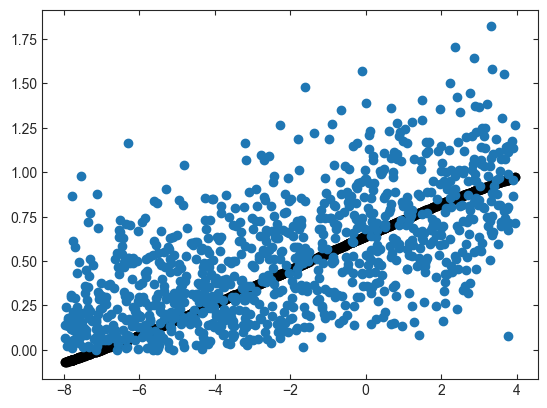

In [9]:
test_sfrs = torch.from_numpy(np.random.uniform(-8, 4, 1000))
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
mean_dust2 = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, scatter, 0.0, 4.0, len(test_sfrs)))

In [10]:
#torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')

mean: 0.04282041040876255 std: 0.0045248492149276434
[0.375 0.625 0.875 1.125 1.375] [-0.07629273 -0.08774544 -0.14971769 -0.13227497 -0.11631106] [0.08744775 0.08570843 0.08565033 0.04772491 0.04331987]


<ErrorbarContainer object of 3 artists>

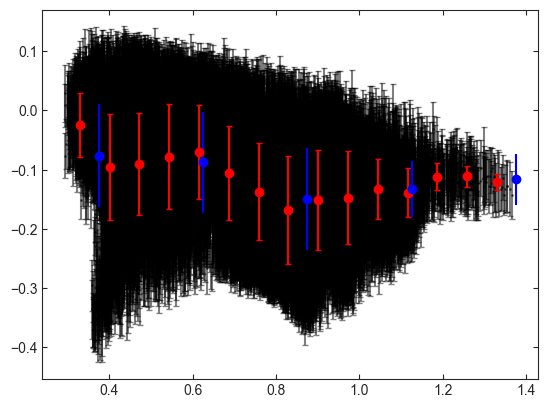

In [11]:
print("mean:", np.mean(ne), "std:", np.std(ne))

bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, n, 'mean', 15)
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, n, 'std', 15)
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2

plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

tau_bins = np.arange(0.25, 4.25, 0.25)
x, y, yerr = binned_weighted_mean_std(tau, n, ne, tau_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')

<ErrorbarContainer object of 3 artists>

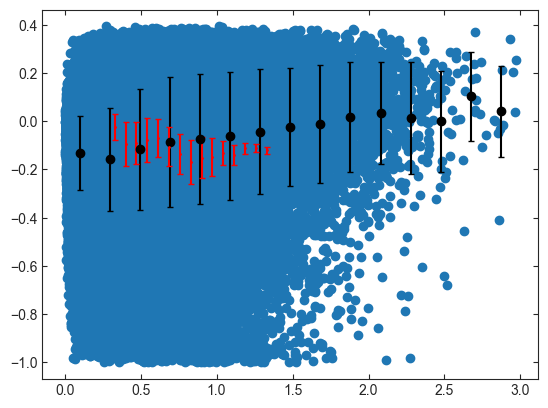

In [12]:
plt.scatter(dust2, dust_index)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust_index,'mean', 15)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust_index,'std', 15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

284.76667563380346
262.8651600005806
240.83575341567877
218.82087020672327
196.9762066542514
175.4692965909138
154.47744294335072
134.1849521419449
114.77961074574704
96.44836226521565
79.37216495153886
63.72004541222676
49.64241682433024
37.26381113395086
26.67528836056948
17.926937448672025
11.021068610324333
5.906896505279071
2.4776808082666273
0.5713504451282195
-0.024503323843555233
-0.02765850531118823
-0.03044288438827428
-0.03305273323463423
-0.03550704928536062
-0.03782118548182181
-0.04000769490055268
-0.04207696343338688
-0.044037684523884936
-0.04589721704516294
-0.04766185697018662
-0.04933704544253694
-0.050927529825259166
-0.05243748985559891
-0.05387063777682853
-0.05523029894229029
-0.05651947765251036
-0.05774091171712699
-0.058897118301146384
-0.05999043292743876
-0.06102304299835179
-0.0619970168216774
-0.06291432884618448
-0.06377688160527945
-0.0645865247166482
-0.06534507117822591
-0.06605431112719604
-0.06671602318185989
-0.06733198346065282
-0.06790397236384309

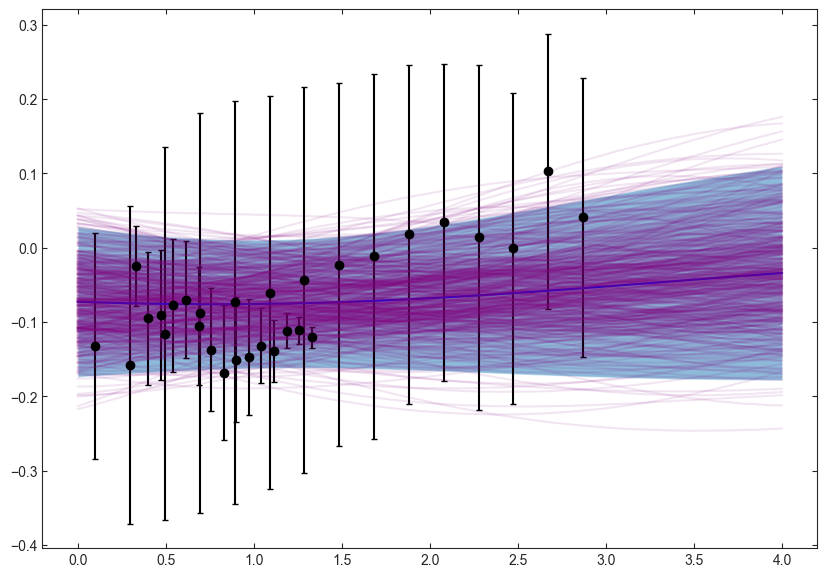

In [13]:
train_dust2 = torch.from_numpy(np.hstack((bin_centers, bin_centers_de)))
train_dust_index = torch.from_numpy(np.hstack((bin_means, bin_means_de)))
train_dust_index_errs = torch.from_numpy(np.hstack((bin_std, bin_std_de)))
test_dust2 = torch.linspace(0, 4, 100)

model, likelihood = create_gp_model_obs([2.0, 6.0], train_dust2, train_dust_index, train_dust_index_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust_index, training_iter=10000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

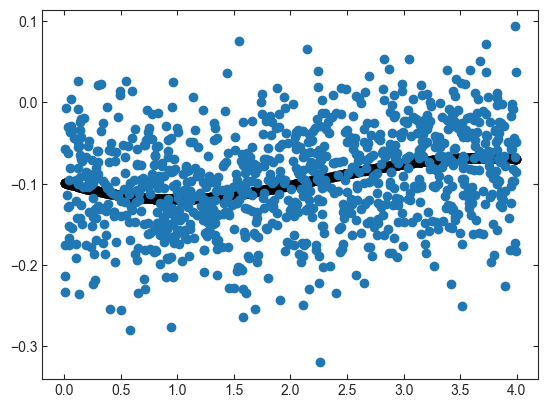

In [14]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_tau)
mean_dust_index = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, scatter, -2.2, 0.4, len(test_tau)))

In [15]:
#torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')

mean: 0.05950431024637405 std: 0.010217651186950893
[0.375 0.625 0.875 1.125 1.375] [0.40325583 0.63559954 0.88154901 1.12980317 1.44394945] [0.05048401 0.07950962 0.08517232 0.07198476 0.08362103]


<ErrorbarContainer object of 3 artists>

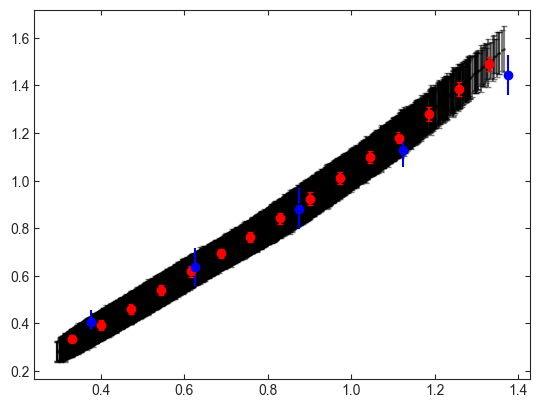

In [16]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)

print("mean:", np.mean(tau1e), "std:", np.std(tau1e))

bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, tau1, 'mean', 15)
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, tau1, 'std', 15)
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2


plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

tau_bins = np.arange(0.25, 4.25, 0.25)
x, y, yerr = binned_weighted_mean_std(tau, tau1, tau1e, tau_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')


<ErrorbarContainer object of 3 artists>

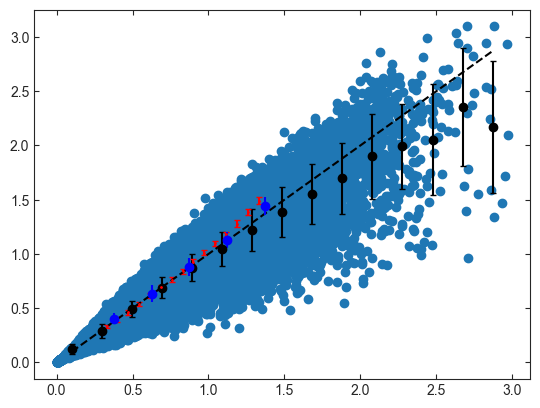

In [17]:
plt.scatter(dust2, dust1)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust1,'mean', 15)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust1,'std', 15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')
plt.errorbar(x, y, yerr, fmt='bo')

2734.3963024374084
2650.2953794517207
2563.4538590031084
2474.060866403247
2382.3359423190695
2288.5285789617874
2192.917121290564
2095.8070062033294
1997.528337743543
1898.4328240141353
1798.8901297628759
1699.2837243099843
1600.0063250307303
1501.4550507955723
1404.0264076215876
1308.1112308720951
1214.0897052749913
1122.326576375392
1033.1666554628403
946.9307054372545
863.9117786464014
784.3720606586248
708.5402573404347
636.6095473636029
568.7361089377229
505.03821840321064
445.5959093019971
390.4511734353117
339.60867985375205
293.03698327489735
250.67018965331857
212.41004314437674
178.12839519347875
147.67001274146043
120.85567848584921
97.48553183123775
77.34259478126992
60.19642285986348
45.80681756931308
33.927534307074396
24.309918475982272
16.706403088205896
10.873803741023812
6.57635156290655
3.588411569823255
1.6968426533457808
0.7029658134665768
0.4236777364441175
0.42365188321683894
0.42359045583065547
0.42350048362026965
0.4233880079896816
0.423258179981789
0.42311535

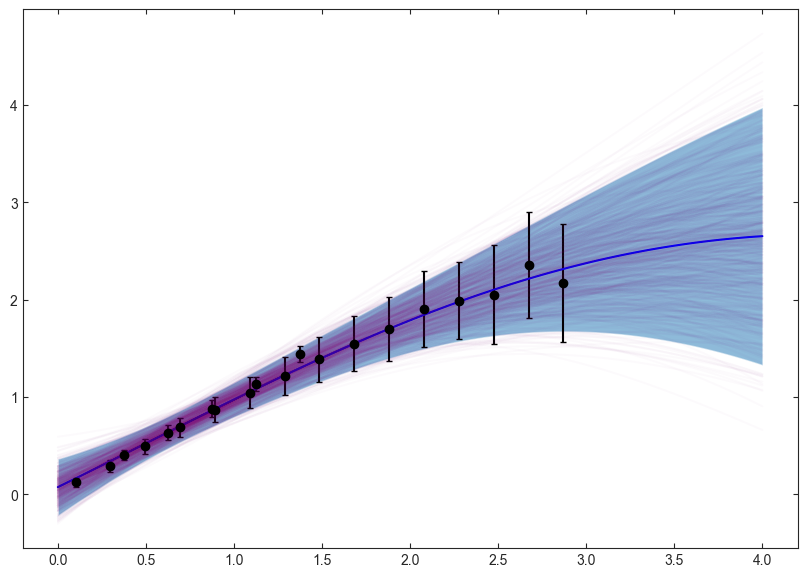

In [18]:
train_dust2 = torch.from_numpy(np.hstack((bin_centers, x)))
train_dust1 = torch.from_numpy(np.hstack((bin_means, y)))
train_dust1_errs = torch.from_numpy(np.hstack((bin_std, yerr)))
test_dust2 = torch.linspace(0, 4, 100)

model, likelihood = create_gp_model_obs([4.0, 10.0], train_dust2, train_dust1, train_dust1_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust1, training_iter=10000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.02)

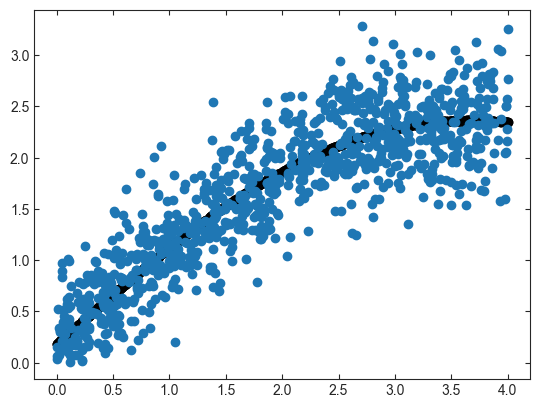

In [19]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_tau)
mean_dust1 = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, scatter, 0.0, 4.0, len(test_tau)))

In [20]:
#torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')